In [1]:
import os
import sys
import numpy as np
from tqdm.notebook import tqdm
from matchms.importing import load_from_json
import tensorflow as tf
from tensorflow.keras.utils import to_categorical

path_root = os.path.dirname(os.getcwd())
path_data = os.path.join(os.path.dirname(path_root), "Data")  # add your local data folder here

## Load spectra 
- imported, cleaned by matchms + Pubchem lookup
- processed (intensity normalization, peak removal outside 10.0-1000.0 Da, minimum 5 peaks)
- remove spectra without InChIKey + smiles/inchi

In [2]:
import pickle

outfile = os.path.join(path_data, 'GNPS_all', 'ALL_GNPS_210409_positive_processed_annotated.pickle')
with open(outfile, 'rb') as file:
    spectrums = pickle.load(file)

print("number of spectra:", len(spectrums))

number of spectra: 250371


In [3]:
def count_annotations(spectrums):
    inchi_lst = []
    smiles_lst = []
    inchikey_lst = []
    for i, spec in enumerate(spectrums):
        inchi_lst.append(spec.get("inchi"))
        smiles_lst.append(spec.get("smiles"))
        inchikey = spec.get("inchikey")
        if inchikey is None:
            inchikey = spec.get("inchikey_inchi")
        inchikey_lst.append(inchikey)

    inchi_count = sum([1 for x in inchi_lst if x])
    smiles_count = sum([1 for x in smiles_lst if x])
    inchikey_count = sum([1 for x in inchikey_lst if x])
    print("Inchis:", inchi_count, "--", len(set(inchi_lst)), "unique")
    print("Smiles:", smiles_count, "--", len(set(smiles_lst)), "unique")
    print("Inchikeys:", inchikey_count, "--", 
          len(set([x[:14] for x in inchikey_lst if x])), "unique (first 14 characters)")

In [4]:
count_annotations(spectrums)

Inchis: 250371 -- 20395 unique
Smiles: 250371 -- 26760 unique
Inchikeys: 250371 -- 17106 unique (first 14 characters)


## Create reference scores (Tanimoto)
- Check better alternatives?

In [5]:
from collections import Counter 
  
def most_frequent(List): 
    occurence_count = Counter(List) 
    return occurence_count.most_common(1)[0][0] 

In [6]:
inchikeys_list = []
for s in spectrums:
    inchikeys_list.append(s.get("inchikey"))

inchikeys14_array = np.array([x[:14] for x in inchikeys_list])

In [7]:
inchikeys14_unique = list({x[:14] for x in inchikeys_list})
len(inchikeys14_unique)

17106

In [8]:
inchikey14 = inchikeys14_unique[2]
print(inchikey14)

idx = np.where(inchikeys14_array == inchikey14)[0]
for i in idx:
    print(spectrums[i].get("smiles") + "\n")

print("most frequent:", most_frequent([spectrums[i].get("smiles") for i in idx]))

WUGMTNYESVFCDC
[H]OC(=O)[C@@]([H])(N([H])C(=O)[C@@]([H])(N([H])C(=O)C1=C(O[H])C(O[H])=C([H])C([H])=C1[H])C([H])([H])C([H])([H])C([H])([H])N([H])C(=N[H])N([H])[H])[C@]([H])(OC(=O)[C@@]([H])(N([H])C(=O)[C@@]([H])(N([H])C(=O)C1=C(O[H])C(O[H])=C([H])C([H])=C1[H])C([H])([H])C([H])([H])C([H])([H])N([H])C(=N[H])N([H])[H])[C@]([H])(O[H])C([H])([H])[H])C([H])([H])[H]

most frequent: [H]OC(=O)[C@@]([H])(N([H])C(=O)[C@@]([H])(N([H])C(=O)C1=C(O[H])C(O[H])=C([H])C([H])=C1[H])C([H])([H])C([H])([H])C([H])([H])N([H])C(=N[H])N([H])[H])[C@]([H])(OC(=O)[C@@]([H])(N([H])C(=O)[C@@]([H])(N([H])C(=O)C1=C(O[H])C(O[H])=C([H])C([H])=C1[H])C([H])([H])C([H])([H])C([H])([H])N([H])C(=N[H])N([H])[H])[C@]([H])(O[H])C([H])([H])[H])C([H])([H])[H]


In [9]:
inchi_list = []
for s in spectrums:
    inchi_list.append(s.get("inchi"))

inchi_array = np.array(inchi_list)

In [10]:
inchi_mapping = []
ID_mapping = []

for inchikey14 in inchikeys14_unique:
    idx = np.where(inchikeys14_array == inchikey14)[0]
    
    inchi = most_frequent([spectrums[i].get("inchi") for i in idx])
    inchi_mapping.append(inchi)
    ID = idx[np.where(inchi_array[idx] == inchi)[0][0]]
    ID_mapping.append(ID)

In [11]:
import pandas as pd
metadata = pd.DataFrame(list(zip(inchikeys14_unique, inchi_mapping, ID_mapping)), columns=["inchikey", "inchi", "ID"])
metadata.head()

,inchikey,inchi,ID
0,ZJXVNNSMRGTDBI,InChI=1S/C15H8O7/c16-6-3-8-12(10(18)4-6)14(20)...,11301
1,PQXBZFLVJGBOAD,"InChI=1S/C15H23NO5/c1-5-6-7-8-10-15(3,19)13(17...",12904
2,WUGMTNYESVFCDC,InChI=1S/C34H48N10O13/c1-15(45)23(43-29(52)19(...,29834
3,LJAIXMQYBNEUSB,InChI=1S/C30H52N2O5/c1-18(7-10-26(35)32-24(28(...,3147
4,TVQZAMVBTVNYLA,InChI=1S/C15H13NO3/c1-9(15(17)18)10-4-5-13-12(...,9632


In [14]:
metadata[metadata["inchikey"] == "VQNWOYVWHDVFJY"]

,inchikey,inchi,ID
7380,VQNWOYVWHDVFJY,InChI=1S/C40H64N6O6/c1-14-15-16-18-21-28(8)37(...,29825


In [12]:
import pandas as pd
metadata = pd.DataFrame(list(zip(inchikeys14_unique, inchi_mapping, ID_mapping)), columns=["inchikey", "inchi", "ID"])
metadata.head()

,inchikey,inchi,ID
0,STZYTFJPGGDRJD,InChI=1S/C30H47NO4S/c1-7-28(4)16-24(35-25(33)1...,9914
1,SWTDXMBCOHIACK,InChI=1S/C27H32O7/c1-25(2)19(12-20(28)32-5)27(...,89952
2,HJBWJAPEBGSQPR,InChI=1S/C11H12O4/c1-14-9-5-3-8(4-6-11(12)13)7...,11055
3,VQNWOYVWHDVFJY,InChI=1S/C40H64N6O6/c1-14-15-16-18-21-28(8)37(...,29825
4,WFDXOXNFNRHQEC,InChI=1S/C22H17N3O5/c1-27-13-17(22(26)28-2)16-...,21467


In [15]:
spectrums[11055].get("inchikey")

'HJBWJAPEBGSQPR-GQCTYLIASA-N'

In [13]:
metadata.to_csv("metadata_AllInchikeys_data210409_positive.csv")

In [16]:
metadata = pd.read_csv("metadata_AllInchikeys_data210409_positive.csv")
metadata.head()

,Unnamed: 0,inchikey,inchi,ID
0,0,STZYTFJPGGDRJD,InChI=1S/C30H47NO4S/c1-7-28(4)16-24(35-25(33)1...,9914
1,1,SWTDXMBCOHIACK,InChI=1S/C27H32O7/c1-25(2)19(12-20(28)32-5)27(...,89952
2,2,HJBWJAPEBGSQPR,InChI=1S/C11H12O4/c1-14-9-5-3-8(4-6-11(12)13)7...,11055
3,3,VQNWOYVWHDVFJY,InChI=1S/C40H64N6O6/c1-14-15-16-18-21-28(8)37(...,29825
4,4,WFDXOXNFNRHQEC,InChI=1S/C22H17N3O5/c1-27-13-17(22(26)28-2)16-...,21467


In [14]:
metadata.ID.values.shape

(17106,)

## Add fingerprints (where necessary)

In [17]:
from matchms.filtering.add_fingerprint import add_fingerprint
from tqdm.notebook import tqdm

for i in tqdm(metadata.ID.values):
    spectrums[i] = add_fingerprint(spectrums[i],
                                   fingerprint_type="daylight", nbits=2048)

  0%|          | 0/17106 [00:00<?, ?it/s]

In [18]:
for i in tqdm(metadata.ID.values):
    if np.any(np.isnan(spectrums[i].get("fingerprint"))):
        print(i)

  0%|          | 0/17106 [00:00<?, ?it/s]

In [19]:
from matchms.similarity import FingerprintSimilarity
import time

spectrums_represent = [spectrums[i] for i in metadata.ID.values]

similarity_measure = FingerprintSimilarity(similarity_measure="jaccard")
tstart = time.time()
scores_mol_similarity = similarity_measure.matrix(spectrums_represent, spectrums_represent)
tend = time.time()
print(f"Calculation took {tend-tstart:.2f} s.")

Calculation took 1376.32 s.


In [20]:
filename = os.path.join(path_data, "similarities_ALL_GNPS_210409_positive_daylight2048_jaccard.npy")
np.save(filename, scores_mol_similarity)

In [21]:
scores_mol_similarity.shape

(17106, 17106)

In [22]:
tanimoto_df = pd.DataFrame(scores_mol_similarity, columns=metadata.inchikey.values, index=metadata.inchikey.values)
tanimoto_df.head()

,STZYTFJPGGDRJD,SWTDXMBCOHIACK,HJBWJAPEBGSQPR,VQNWOYVWHDVFJY,WFDXOXNFNRHQEC,GZLIPAFSJXROEC,YTZSBJLNMIQROD,FOULCGVQZYQEQM,BPSJMBKZSUTYNF,PZJVSTTVMXPZCJ,...,VLSRUFWCGBMYDJ,SXXHPCVDFDABHW,MRHAPHFJBAUDTR,ZYCWGZVLCXRARB,CGUNOWXWUXNOPE,MGRVRXRGTBOSHW,WELCNKRQSNXMDQ,XFANDVLPSBUGKD,NDTYTMIUWGWIMO,OAUIRSVJXOFAOO
STZYTFJPGGDRJD,1.000000,0.377404,0.124056,0.269856,0.233411,0.258824,0.354221,0.227136,0.277537,0.316971,...,0.112832,0.177950,0.277099,0.308905,0.341988,0.017219,0.274643,0.298611,0.138404,0.270531
SWTDXMBCOHIACK,0.377404,1.000000,0.158318,0.274962,0.297240,0.324305,0.372534,0.216172,0.274742,0.351300,...,0.140399,0.184380,0.325533,0.353607,0.387618,0.014911,0.364401,0.371447,0.153314,0.366841
HJBWJAPEBGSQPR,0.124056,0.158318,1.000000,0.159198,0.209205,0.200203,0.133133,0.106944,0.201604,0.157643,...,0.753012,0.152395,0.180529,0.188280,0.147473,0.005848,0.199245,0.234842,0.074725,0.180833
VQNWOYVWHDVFJY,0.269856,0.274962,0.159198,1.000000,0.270677,0.261011,0.218063,0.237487,0.228497,0.471683,...,0.149272,0.216159,0.591716,0.370402,0.279240,0.014306,0.288416,0.314224,0.100515,0.262040
WFDXOXNFNRHQEC,0.233411,0.297240,0.209205,0.270677,1.000000,0.329466,0.273837,0.184561,0.258525,0.355102,...,0.194030,0.212011,0.330603,0.312870,0.318026,0.017301,0.319708,0.357045,0.083333,0.351071


In [23]:
filename = os.path.join(path_data, "ALL_GNPS_210409_positive_tanimoto_scores.pickle")
tanimoto_df.to_pickle(filename)

# Compute t-SNE positions

In [41]:
from matchms.filtering.add_fingerprint import add_fingerprint
from tqdm.notebook import tqdm

for i in tqdm(metadata.ID.values):
    spectrums[i] = add_fingerprint(spectrums[i],
                                   fingerprint_type="morgan3", nbits=512)

  0%|          | 0/17106 [00:00<?, ?it/s]

In [42]:
for i in tqdm(metadata.ID.values):
    if np.any(np.isnan(spectrums[i].get("fingerprint"))):
        print(i)

  0%|          | 0/17106 [00:00<?, ?it/s]

In [45]:
spectrums[metadata.ID.values[0]].get("fingerprint")

array([0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,

In [44]:
np.sum(spectrums[0].get("fingerprint") == 1)

119

In [52]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, perplexity=50, random_state=0)

In [48]:
fingerprints = np.array([spectrums[i].get("fingerprint") for i in metadata.ID.values])
fingerprints.shape

(17106, 512)

In [51]:
fingerprints

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 1, 0],
       [0, 1, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 1]])

In [53]:
X_2d = tsne.fit_transform(fingerprints)

In [54]:
X_2d.shape

(17106, 2)

In [77]:
tsne_inchikey_x_y = {metadata.inchikey.values[i]:X_2d[i, :] for i in range(X_2d.shape[0])}

In [130]:
pickle.dump(tsne_inchikey_x_y, 
            open(os.path.join(path_data, 'GNPS_all', 'ALL_GNPS_210409_tsne_coordinates.pickle'), "wb"))

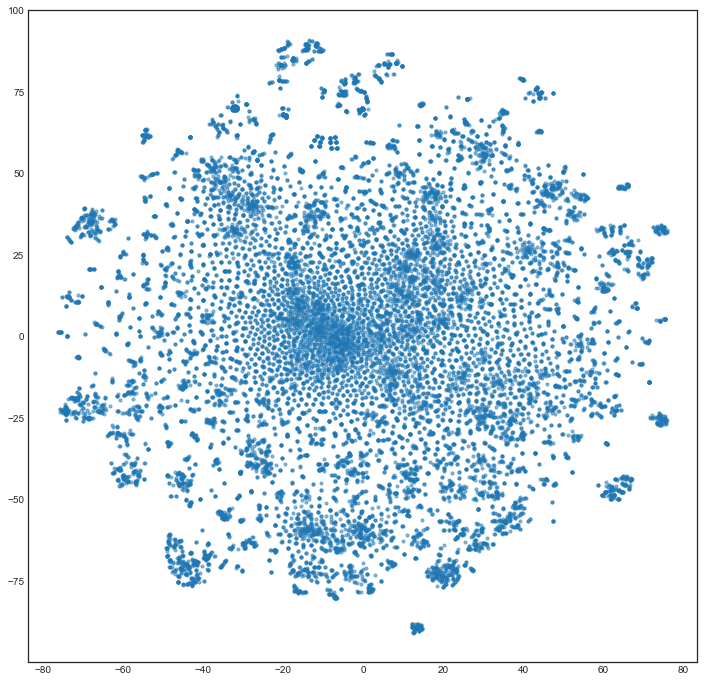

In [58]:
from matplotlib import pyplot as plt

plt.figure(figsize=(12,12))
plt.style.use('seaborn-white')
plt.scatter(X_2d[:,0], X_2d[:,1], s=10, alpha=0.5)

In [63]:
filename = "top_20_matches_899_validation_spectra.pickle"
with open(filename, 'rb') as file:
    ms2query_results = pickle.load(file)

In [67]:
ms2query_results['CCMSLIB00000004652']

,parent_mass,mass_sim,s2v_scores,ms2ds_scores,ms2query_model_prediction
CCMSLIB00005777160,0.026540,2.196054e-11,0.062497,0.735383,0.321281
CCMSLIB00000207943,0.020651,9.992312e-04,0.292261,0.733451,0.318350
CCMSLIB00000207937,0.020651,9.992312e-04,0.275895,0.730936,0.315730
CCMSLIB00005775026,0.020354,2.431920e-03,0.160278,0.744636,0.311396
CCMSLIB00005773922,0.020354,2.431920e-03,0.160278,0.743367,0.311380
CCMSLIB00000207942,0.020651,9.992312e-04,0.226015,0.738071,0.310861
CCMSLIB00005774020,0.020651,9.992312e-04,0.144051,0.744690,0.309644
CCMSLIB00005774345,0.020354,2.431920e-03,0.084953,0.745855,0.303731
CCMSLIB00005772989,0.020354,2.431920e-03,0.059798,0.745338,0.290910
CCMSLIB00005750134,0.019984,7.345841e-03,0.068190,0.745693,0.290020


In [100]:
ms2query_results['CCMSLIB00000004652'].iloc[0]["ms2query_model_prediction"]

0.3212807774543762

In [75]:
spec_id_inchikey_mapping = {s.get("spectrum_id"):s.get("inchikey")[:14] for s in spectrums}

In [79]:
spec_id_inchikey_mapping["CCMSLIB00005777160"]

'HYAFETHFCAUJAY'

In [80]:
spectrum_id = "CCMSLIB00005777160"
inchikey14 = spec_id_inchikey_mapping[spectrum_id]
tsne_inchikey_x_y[inchikey14]

array([-2.50881 , 10.150314], dtype=float32)

In [135]:
mixture_results_high = []
mixture_results_moderate = []

for key in ms2query_results.keys():
    top_spectrum_id = ms2query_results[key].index[0]
    prediction = ms2query_results[key].iloc[0]["ms2query_model_prediction"]
    if prediction > 0.8:
        if top_spectrum_id in spec_id_inchikey_mapping:
            inchikey14 = spec_id_inchikey_mapping[top_spectrum_id]
            mixture_results_high.append(tsne_inchikey_x_y[inchikey14])
    elif prediction > 0.5:
        if top_spectrum_id in spec_id_inchikey_mapping:
            inchikey14 = spec_id_inchikey_mapping[top_spectrum_id]
            mixture_results_moderate.append(tsne_inchikey_x_y[inchikey14])

715 analogues found


([], [])

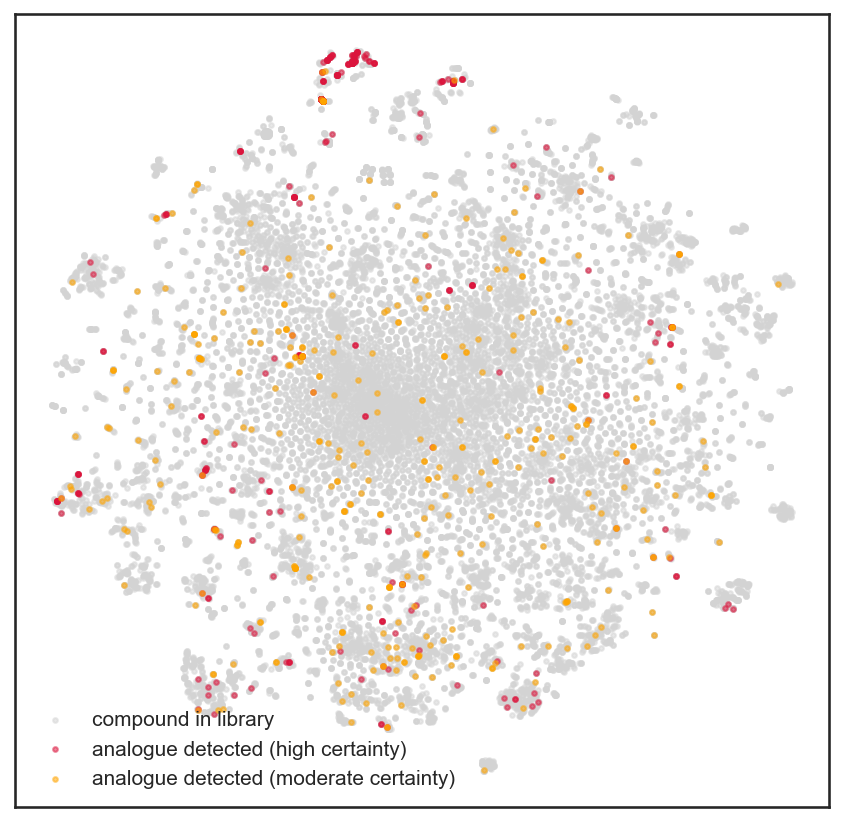

In [138]:
analogues_high = np.array(mixture_results_high)
analogues_moderate = np.array(mixture_results_moderate)

print(f"{analogues_moderate.shape[0] + analogues_high.shape[0]} analogues found")


fig, ax = plt.subplots(figsize=(7, 7), dpi=150)
plt.style.use('seaborn-white')
ax.scatter(X_2d[:,0], X_2d[:,1], s=5, alpha=0.5, color="lightgray", label="compound in library")
ax.scatter(analogues_high[:,0], analogues_high[:,1], s=5, alpha=0.5, color="crimson",
           label="analogue detected (high certainty)")
ax.scatter(analogues_moderate[:,0], analogues_moderate[:,1], s=5, alpha=0.5, color="orange", # color="dodgerblue",
           label="analogue detected (moderate certainty)")
plt.legend()
plt.xticks([])
plt.yticks([])

# Compare to UMAP

In [140]:
import umap

In [141]:
mapper = umap.UMAP().fit(fingerprints)

In [159]:
umap_2d = umap.UMAP(n_components=2, n_neighbors=1000, min_dist=0.99, init='random', random_state=0)
proj_2d = umap_2d.fit_transform(fingerprints)

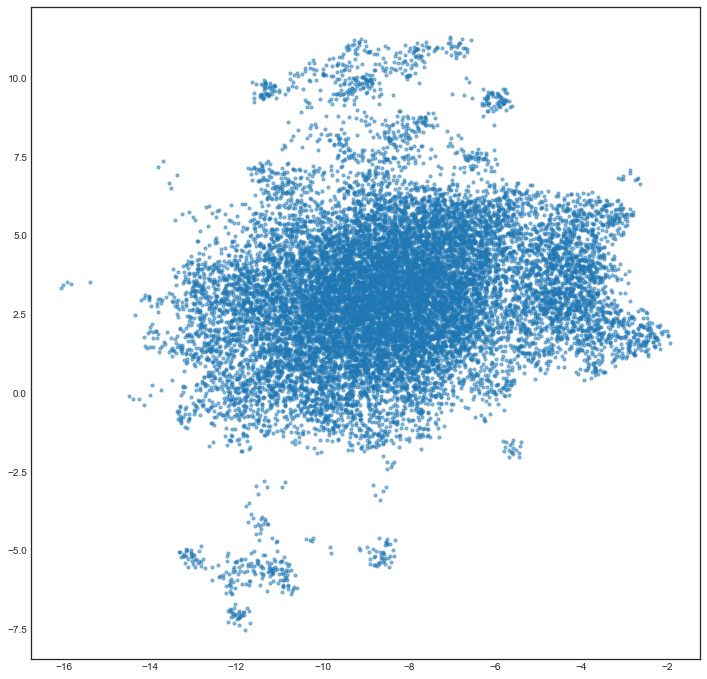

In [160]:
from matplotlib import pyplot as plt

plt.figure(figsize=(12,12))
plt.style.use('seaborn-white')
plt.scatter(proj_2d[:,0], proj_2d[:,1], s=10, alpha=0.5)

In [155]:
umap_inchikey_x_y = {metadata.inchikey.values[i]:proj_2d[i, :] for i in range(proj_2d.shape[0])}

In [156]:
pickle.dump(umap_inchikey_x_y, 
            open(os.path.join(path_data, 'GNPS_all', 'ALL_GNPS_210409_umap_coordinates.pickle'), "wb"))

In [157]:
mixture_results_high = []
mixture_results_moderate = []

for key in ms2query_results.keys():
    top_spectrum_id = ms2query_results[key].index[0]
    prediction = ms2query_results[key].iloc[0]["ms2query_model_prediction"]
    if prediction > 0.8:
        if top_spectrum_id in spec_id_inchikey_mapping:
            inchikey14 = spec_id_inchikey_mapping[top_spectrum_id]
            mixture_results_high.append(umap_inchikey_x_y[inchikey14])
    elif prediction > 0.5:
        if top_spectrum_id in spec_id_inchikey_mapping:
            inchikey14 = spec_id_inchikey_mapping[top_spectrum_id]
            mixture_results_moderate.append(umap_inchikey_x_y[inchikey14])

715 analogues found


([], [])

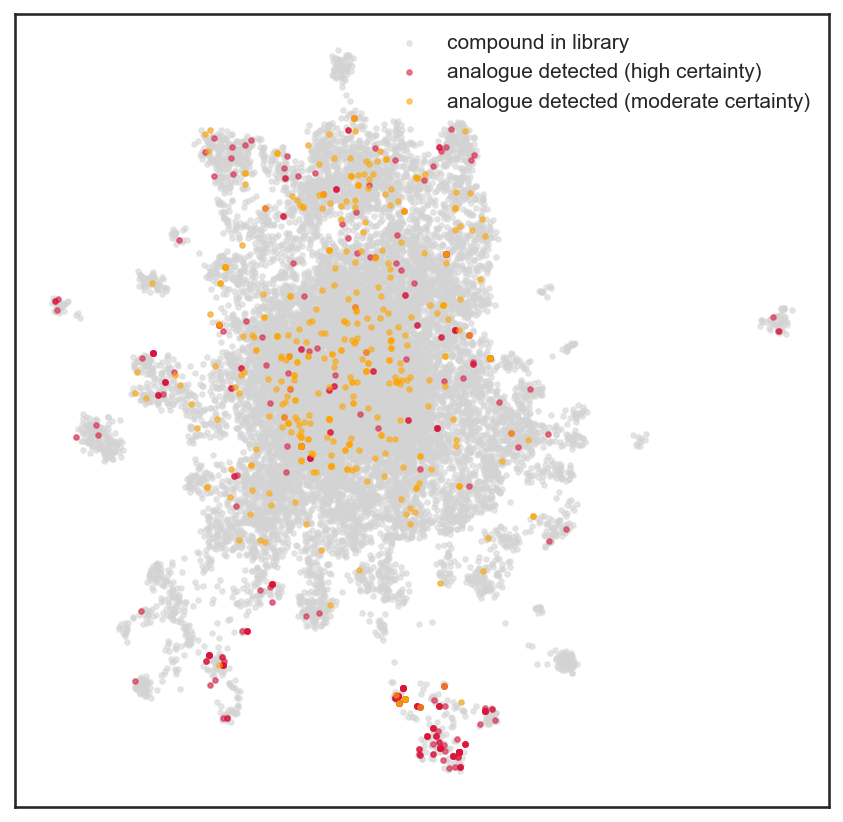

In [158]:
analogues_high = np.array(mixture_results_high)
analogues_moderate = np.array(mixture_results_moderate)

print(f"{analogues_moderate.shape[0] + analogues_high.shape[0]} analogues found")


fig, ax = plt.subplots(figsize=(7, 7), dpi=150)
plt.style.use('seaborn-white')
ax.scatter(proj_2d[:,0], proj_2d[:,1], s=5, alpha=0.5, color="lightgray", label="compound in library")
ax.scatter(analogues_high[:,0], analogues_high[:,1], s=5, alpha=0.5, color="crimson",
           label="analogue detected (high certainty)")
ax.scatter(analogues_moderate[:,0], analogues_moderate[:,1], s=5, alpha=0.5, color="orange", # color="dodgerblue",
           label="analogue detected (moderate certainty)")
plt.legend()
plt.xticks([])
plt.yticks([])

In [163]:
umap_inchikey_x_y = {metadata.inchikey.values[i]:proj_2d[i, :] for i in range(proj_2d.shape[0])}

In [164]:
pickle.dump(umap_inchikey_x_y, 
            open(os.path.join(path_data, 'GNPS_all', 'ALL_GNPS_210409_umap_coordinates_neighbor1000.pickle'), "wb"))

In [165]:
mixture_results_high = []
mixture_results_moderate = []

for key in ms2query_results.keys():
    top_spectrum_id = ms2query_results[key].index[0]
    prediction = ms2query_results[key].iloc[0]["ms2query_model_prediction"]
    if prediction > 0.8:
        if top_spectrum_id in spec_id_inchikey_mapping:
            inchikey14 = spec_id_inchikey_mapping[top_spectrum_id]
            mixture_results_high.append(umap_inchikey_x_y[inchikey14])
    elif prediction > 0.5:
        if top_spectrum_id in spec_id_inchikey_mapping:
            inchikey14 = spec_id_inchikey_mapping[top_spectrum_id]
            mixture_results_moderate.append(umap_inchikey_x_y[inchikey14])

715 analogues found


([], [])

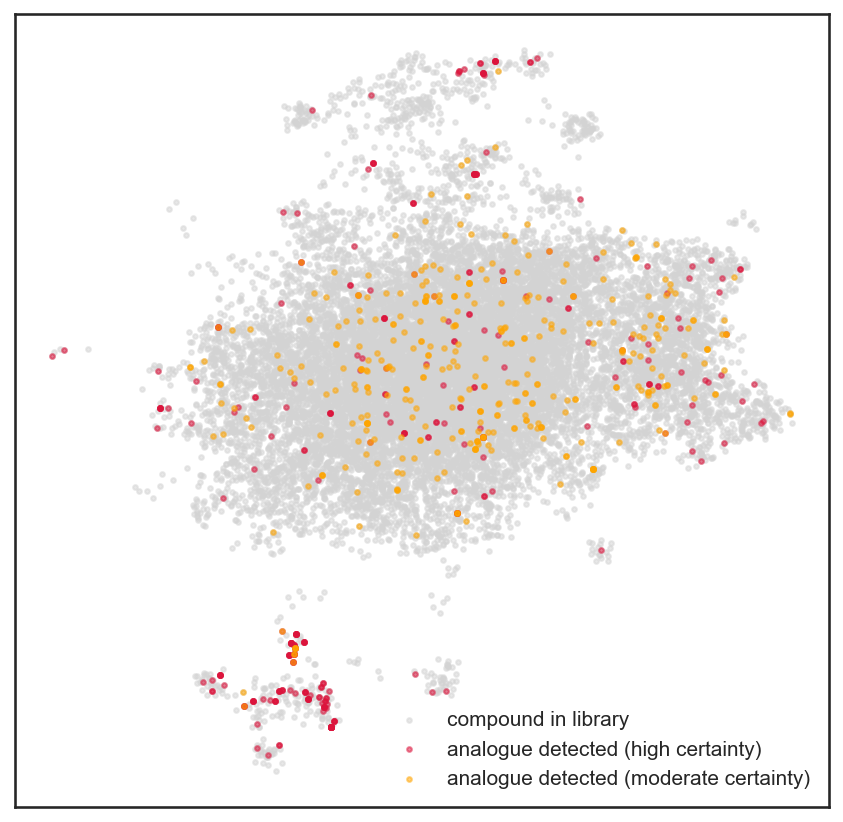

In [166]:
analogues_high = np.array(mixture_results_high)
analogues_moderate = np.array(mixture_results_moderate)

print(f"{analogues_moderate.shape[0] + analogues_high.shape[0]} analogues found")


fig, ax = plt.subplots(figsize=(7, 7), dpi=150)
plt.style.use('seaborn-white')
ax.scatter(proj_2d[:,0], proj_2d[:,1], s=5, alpha=0.5, color="lightgray", label="compound in library")
ax.scatter(analogues_high[:,0], analogues_high[:,1], s=5, alpha=0.5, color="crimson",
           label="analogue detected (high certainty)")
ax.scatter(analogues_moderate[:,0], analogues_moderate[:,1], s=5, alpha=0.5, color="orange", # color="dodgerblue",
           label="analogue detected (moderate certainty)")
plt.legend()
plt.xticks([])
plt.yticks([])